In [0]:
import os
import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU Available')
else:
    print("Please install GPU version of TF")

GPU Available


In [0]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"
%cd /content/drive/My Drive/Kaggle

/content/drive/My Drive/Kaggle


In [0]:
!kaggle competitions download -c quora-question-pairs

403 - Forbidden


In [0]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.5MB 45.0MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 7.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=4e9f3e995dd752c08aedf21e2958261edcfc9f6295d4cc0a14ef6869469046be
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle
Kaggle API 1.5.6


In [0]:
!kaggle competitions download -c quora-question-pairs

 97% 301M/309M [00:02<00:00, 114MB/s]
100% 309M/309M [00:02<00:00, 111MB/s]


In [0]:
!unzip 'quora-question-pairs.zip'

Archive:  quora-question-pairs.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv                
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [0]:
os.listdir()

['train.csv',
 'sample_submission.csv.zip',
 'test.csv',
 'test.csv.zip',
 'train.csv.zip',
 'kaggle.json',
 'quora-question-pairs.zip',
 'model_plot.png']

In [0]:
!unzip 'train.csv.zip'

Archive:  train.csv.zip
  inflating: train.csv               


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
import keras
from keras import backend as K
from keras.engine.topology import Layer
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant
from keras.layers.merge import add

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import np_utils
from keras import regularizers
from keras.regularizers import l2

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
import os

In [0]:
data=pd.read_csv('train.csv')
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
data['text']=data['question1']+' '+data['question2']
data.fillna(' ',inplace=True)

Text(0.5, 1.0, 'Question Pairs')

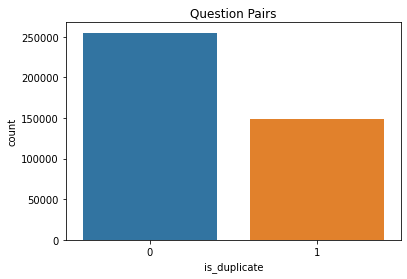

In [0]:
sns.countplot(data.is_duplicate).set_title('Question Pairs')

In [0]:
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
text            0
dtype: int64

In [0]:
data=data[:10000]

In [0]:
data

,id,qid1,qid2,question1,question2,is_duplicate,text
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely? How can I solve...
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"Which one dissolve in water quikly sugar, salt..."
...,...,...,...,...,...,...,...
9995,9995,19404,19405,How would you order these four cities (Bangalo...,What is the cost of living in Europe and the U...,0,How would you order these four cities (Bangalo...
9996,9996,19406,19407,Stphen william hawking?,"What are the differences between SM, YG and JY...",0,Stphen william hawking? What are the differenc...
9997,9997,19408,19409,Mathematical Puzzles: What is () + () + () = 3...,What are the steps to solve this equation: [ma...,0,Mathematical Puzzles: What is () + () + () = 3...
9998,9998,19410,19411,Is IMS noida good for BCA?,How good is IMS Noida for studying BCA?,1,Is IMS noida good for BCA? How good is IMS Noi...


In [0]:
sw=[]
sw=data['text']
sw

0       What is the step by step guide to invest in sh...
1       What is the story of Kohinoor (Koh-i-Noor) Dia...
2       How can I increase the speed of my internet co...
3       Why am I mentally very lonely? How can I solve...
4       Which one dissolve in water quikly sugar, salt...
                              ...                        
9995    How would you order these four cities (Bangalo...
9996    Stphen william hawking? What are the differenc...
9997    Mathematical Puzzles: What is () + () + () = 3...
9998    Is IMS noida good for BCA? How good is IMS Noi...
9999    What are the most respected and informative te...
Name: text, Length: 10000, dtype: object

In [0]:
stop_words = set(stopwords.words('english'))
ws=[]
for example_sent in sw:
  word_tokens = word_tokenize(example_sent) 
  filtered_sentence = [w for w in word_tokens if not w in stop_words]
  ws.append(filtered_sentence)

In [0]:
for i in range(len(ws)):
  ws[i]= [word for word in ws[i] if word.isalpha()]

In [0]:
lemma=WordNetLemmatizer()
for i in range(len(ws)):
  for j in range(len(ws[i])):
    ws[i][j]=lemma.lemmatize(ws[i][j]) 

In [0]:
data['text_number']=ws

In [0]:
sw=[]
sw=data['question1']
stop_words = set(stopwords.words('english'))
ws=[]
for example_sent in sw:
  word_tokens = word_tokenize(example_sent) 
  filtered_sentence = [w for w in word_tokens if not w in stop_words]
  ws.append(filtered_sentence)
for i in range(len(ws)):
  ws[i]= [word for word in ws[i] if word.isalpha()]

lemma=WordNetLemmatizer()
for i in range(len(ws)):
  for j in range(len(ws[i])):
    ws[i][j]=lemma.lemmatize(ws[i][j]) 

data['question1_number']=ws

In [0]:
sw=[]
sw=data['question2']
stop_words = set(stopwords.words('english'))
ws=[]
for example_sent in sw:
  word_tokens = word_tokenize(example_sent) 
  filtered_sentence = [w for w in word_tokens if not w in stop_words]
  ws.append(filtered_sentence)
for i in range(len(ws)):
  ws[i]= [word for word in ws[i] if word.isalpha()]

lemma=WordNetLemmatizer()
for i in range(len(ws)):
  for j in range(len(ws[i])):
    ws[i][j]=lemma.lemmatize(ws[i][j]) 

data['question2_number']=ws

In [0]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,text,text_number,question1_number,question2_number
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...,"[What, step, step, guide, invest, share, marke...","[What, step, step, guide, invest, share, marke...","[What, step, step, guide, invest, share, market]"
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor (Koh-i-Noor) Dia...,"[What, story, Kohinoor, Diamond, What, would, ...","[What, story, Kohinoor, Diamond]","[What, would, happen, Indian, government, stol..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...,"[How, I, increase, speed, internet, connection...","[How, I, increase, speed, internet, connection...","[How, Internet, speed, increased, hacking, DNS]"
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely? How can I solve...,"[Why, I, mentally, lonely, How, I, solve, Find...","[Why, I, mentally, lonely, How, I, solve]","[Find, remainder, math, divided]"
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"Which one dissolve in water quikly sugar, salt...","[Which, one, dissolve, water, quikly, sugar, s...","[Which, one, dissolve, water, quikly, sugar, s...","[Which, fish, would, survive, salt, water]"


In [0]:
ss=[]
for i in range(len(data)):
  lst=data.iloc[i,7]
  listToStr = ' '.join(map(str, lst))
  ss.append(listToStr)
data['text_number']=ss

In [0]:
ss=[]
for i in range(len(data)):
  lst=data.iloc[i,8]
  listToStr = ' '.join(map(str, lst))
  ss.append(listToStr)
data['question1_number']=ss

In [0]:
ss=[]
for i in range(len(data)):
  lst=data.iloc[i,9]
  listToStr = ' '.join(map(str, lst))
  ss.append(listToStr)
data['question2_number']=ss

In [0]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,text,text_number,question1_number,question2_number
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...,What step step guide invest share market india...,What step step guide invest share market india,What step step guide invest share market
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor (Koh-i-Noor) Dia...,What story Kohinoor Diamond What would happen ...,What story Kohinoor Diamond,What would happen Indian government stole Kohi...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...,How I increase speed internet connection using...,How I increase speed internet connection using...,How Internet speed increased hacking DNS
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely? How can I solve...,Why I mentally lonely How I solve Find remaind...,Why I mentally lonely How I solve,Find remainder math divided
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"Which one dissolve in water quikly sugar, salt...",Which one dissolve water quikly sugar salt met...,Which one dissolve water quikly sugar salt met...,Which fish would survive salt water


In [0]:
x_train,x_test,y_train,y_test = train_test_split(data.text_number,data.is_duplicate,test_size = 0.2 , random_state = 0)

In [0]:
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(x_train)
#transformed test reviews
cv_test_reviews=cv.transform(x_test)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (8000, 128266)
BOW_cv_test: (2000, 128266)


In [0]:
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(x_train)
#transformed test reviews
tv_test_reviews=tv.transform(x_test)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (8000, 128266)
Tfidf_test: (2000, 128266)


In [0]:
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=0)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,y_train)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,y_train)
print(lr_tfidf)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [0]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
#Accuracy score for bag of words
lr_bow_score=accuracy_score(y_test,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(y_test,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.6755
lr_tfidf_score : 0.626


In [0]:
#training the model
mnb=MultinomialNB()
#fitting the nb for bag of words
mnb_bow=mnb.fit(cv_train_reviews,y_train)
print(mnb_bow)
#fitting the nb for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,y_train)
print(mnb_tfidf)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


In [0]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(y_test,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(y_test,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.6805
mnb_tfidf_score : 0.6775


In [0]:
model1 = Sequential()
model1.add(Dense(units = 75 , activation = 'relu' , input_dim = cv_train_reviews.shape[1]))
model1.add(Dense(units = 50 , activation = 'relu'))
model1.add(Dense(units = 25 , activation = 'relu'))
model1.add(Dense(units = 10 , activation = 'relu')) 
model1.add(Dense(units = 1 , activation = 'sigmoid'))
model1.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [0]:
model1.train_on_batch(cv_train_reviews,y_train)

[0.6916475892066956, 0.6269999742507935]

In [0]:
cnn_test_accuracy=model1.test_on_batch(cv_test_reviews,y_test)

In [0]:
cnn_test_accuracy[0]

0.6910623908042908

In [0]:
from xgboost import XGBClassifier

In [0]:
# XGBoost Classifier model3
model2=XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

In [0]:
model2.fit(tv_train_reviews,y_train,eval_metric='auc')

In [0]:
preds=model2.predict(tv_test_reviews)

In [0]:
scoress=accuracy_score(y_test,preds)
print("score :",scoress)

score : 0.6245


In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
rf = RandomForestClassifier(n_estimators = 800,min_samples_leaf = 10,min_samples_split=15)

In [0]:
rf.fit(tv_train_reviews,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
y = rf.predict(tv_test_reviews)

In [0]:
rff=accuracy_score(y_test,y)
print("mnb_bow_score :",rff)

mnb_bow_score : 0.6245


In [0]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,text,text_number,question1_number,question2_number
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...,What step step guide invest share market india...,What step step guide invest share market india,What step step guide invest share market
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor (Koh-i-Noor) Dia...,What story Kohinoor Diamond What would happen ...,What story Kohinoor Diamond,What would happen Indian government stole Kohi...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...,How I increase speed internet connection using...,How I increase speed internet connection using...,How Internet speed increased hacking DNS
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely? How can I solve...,Why I mentally lonely How I solve Find remaind...,Why I mentally lonely How I solve,Find remainder math divided
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"Which one dissolve in water quikly sugar, salt...",Which one dissolve water quikly sugar salt met...,Which one dissolve water quikly sugar salt met...,Which fish would survive salt water


In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.text)
X = tokenizer.texts_to_sequences(data.text)
data['words'] = X

In [0]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,text,text_number,question1_number,question2_number,words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...,What step step guide invest share market india...,What step step guide invest share market india,What step step guide invest share market,"[2, 3, 1, 1269, 57, 1269, 2459, 6, 738, 8, 585..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor (Koh-i-Noor) Dia...,What story Kohinoor Diamond What would happen ...,What story Kohinoor Diamond,What would happen Indian government stole Kohi...,"[2, 3, 1, 442, 10, 6068, 6069, 4, 6070, 3988, ..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...,How I increase speed internet connection using...,How I increase speed internet connection using...,How Internet speed increased hacking DNS,"[5, 13, 4, 189, 1, 515, 10, 17, 349, 1782, 236..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely? How can I solve...,Why I mentally lonely How I solve Find remaind...,Why I mentally lonely How I solve,Find remainder math divided,"[16, 70, 4, 2715, 319, 2716, 5, 13, 4, 783, 19..."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"Which one dissolve in water quikly sugar, salt...",Which one dissolve water quikly sugar salt met...,Which one dissolve water quikly sugar salt met...,Which fish would survive salt water,"[25, 49, 3991, 8, 228, 9072, 1476, 1783, 4802,..."


In [0]:
glove_path='/content/drive/My Drive/glove.6B.50d.txt'

In [0]:
EMBEDDING_DIM = 50

embeddings_index = {}
f = open(glove_path)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

#print('Found %s unique tokens.' % len(word_index))
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [0]:
maxlen = 50
X = list(sequence.pad_sequences(data.words, maxlen=maxlen))

In [0]:
word_index = tokenizer.word_index

In [0]:
unique_words=[*word_index]
unique_words.insert(0, ' ') 
len(unique_words)

15580

In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

In [0]:
embedding_matrix.shape

(15580, 50)

In [0]:
pd.DataFrame(embedding_matrix, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.00000
the,0.418000,0.249680,-0.412420,0.121700,0.34527,-0.044457,-0.496880,-0.178620,-0.000660,-0.656600,0.278430,-0.147670,-0.556770,0.14658,-0.009510,0.011658,0.102040,-0.12792,-0.844300,-0.121810,-0.016801,-0.33279,-0.155200,-0.231310,-0.191810,-1.88230,-0.767460,0.099051,-0.421250,-0.195260,4.00710,-0.18594,-0.522870,-0.31681,0.000592,0.007445,0.17778,-0.158970,0.012041,-0.054223,-0.298710,-0.157490,-0.347580,-0.045637,-0.442510,0.18785,0.002785,-0.18411,-0.11514,-0.78581
what,0.453230,0.059811,-0.105770,-0.333000,0.72359,-0.087170,-0.610530,-0.037695,-0.309450,0.218050,-0.436050,0.473180,-0.768660,-0.27130,1.104200,0.591410,0.569620,-0.18678,0.148670,-0.672920,-0.346720,0.52284,0.229590,-0.072014,0.939670,-2.39850,-1.323800,0.286980,0.755090,-0.765220,3.34250,0.17233,-0.518030,-0.82970,-0.293330,-0.500760,-0.15228,0.098973,0.181460,-0.174200,-0.406660,0.203480,-0.011788,0.482520,0.024598,0.34064,-0.084724,0.53240,-0.25103,0.62546
is,0.618500,0.642540,-0.465520,0.375700,0.74838,0.537390,0.002224,-0.605770,0.264080,0.117030,0.437220,0.200920,-0.057859,-0.34589,0.216640,0.585730,0.539190,0.69490,-0.156180,0.055830,-0.605150,-0.28997,-0.025594,0.555930,0.253560,-1.96120,-0.513810,0.690960,0.066246,-0.054224,3.78710,-0.77403,-0.126890,-0.51465,0.066705,-0.329330,0.13483,0.190490,0.138120,-0.215030,-0.016573,0.312000,-0.331890,-0.026001,-0.382030,0.19403,-0.124660,-0.27557,0.30899,0.48497
i,0.118910,0.152550,-0.082073,-0.741440,0.75917,-0.483280,-0.310090,0.514760,-0.987080,0.000618,-0.150430,0.837700,-1.079700,-0.51460,1.318800,0.620070,0.137790,0.47108,-0.072874,-0.726750,-0.741160,0.75263,0.881800,0.295610,1.354800,-2.57010,-1.352300,0.458800,1.006800,-1.185600,3.47370,0.77898,-0.729290,0.25102,-0.261560,-0.346840,0.55841,0.750980,0.498300,-0.268230,-0.002744,-0.018298,-0.280960,0.553180,0.037706,0.18555,-0.150250,-0.57512,-0.26671,0.92121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
auditions,0.021421,-0.292920,-0.467430,-0.023170,-0.60213,-0.145320,0.005738,1.191900,-0.059322,0.737380,-0.062126,-0.875210,-0.082795,1.04360,0.516840,-0.346260,0.124260,-0.13203,-0.182400,-0.539840,1.257900,0.63241,0.819450,1.470200,-0.616660,0.46406,-0.332950,-0.512040,-1.144400,-0.997300,0.95767,1.10800,-0.138330,-1.29100,0.452420,0.163880,0.96829,-0.044471,-0.314450,-0.662170,-0.710210,-0.256120,-0.946170,-0.005512,-0.511180,-0.32313,0.248040,-0.39083,-0.39216,0.51068
auditioning,0.226820,-0.865980,-0.298330,-0.876850,-0.25402,0.144880,-0.428560,0.729620,-0.778530,0.751990,0.083693,-0.045663,-0.123470,0.98812,0.571910,-0.188750,0.273710,0.83699,0.022428,-0.700200,0.621310,0.73247,0.713180,0.883220,0.281920,0.45577,0.010168,-0.220610,-0.312220,-0.751620,0.26664,0.77738,0.093551,-0.80536,0.677640,0.355830,0.30903,0.331190,-0.647630,-0.438950,-1.098600,0.025122,-0.790640,-0.086698,-0.400280,-1.10130,0.369270,-0.45963,-0.82917,0.81933
6x,-1.677200,0.719170,1.259700,-0.126020,-0.56624,-0.727720,0.091382,-0.017092,1.100700,1.833100,0.765730,-0.424990,0.562710,0.16452,-0.084065,0.300570,0.046771,0.63786,1.335700,-0.023901,-0.326970,0.15118,-0.773110,0.427980,0.085664,0.58046,-0.210800,-0.254240,1.194400,-0.138080,-0.25767,-0.98475,-0.382860,1.23840,0.875910,0.144960,0.44892,0.113960,0.297970,-0.855500,1.025600,-0.701100,0.395260,

In [0]:
X = np.array(X)
Y = np_utils.to_categorical(list(data.is_duplicate))

seed = 29
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [0]:
inp = Input(shape=(maxlen,), dtype='int32')
x = embedding_layer(inp)
x = Bidirectional(LSTM(128, return_sequences=True, name="BiLSTM-1",recurrent_regularizer=l2(0.01)))(x)
x = Dropout(0.5, name="Dropout-1")(x)
x = Bidirectional(LSTM(128, name="BiLSTM-2",recurrent_regularizer=l2(0.01)))(x)
x = Dropout(0.5, name="Dropout-2")(x)
outp = Dense(2, activation='softmax', name="FC-layer")(x)
model = Model(inp, outp)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            779000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 256)           183296    
_________________________________________________________________
Dropout-1 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
Dropout-2 (Dropout)          (None, 256)               0         
_________________________________________________________________
FC-layer (Dense)             (None, 2)                 514   

In [0]:
model_history = model.fit(x_train, y_train, batch_size=128, epochs=15, validation_data=(x_val, y_val))

Epoch 1/15
63/63 [==============================] - 2s 39ms/step - loss: 2.6788 - acc: 0.6271 - val_loss: 1.1321 - val_acc: 0.6350
Epoch 2/15
63/63 [==============================] - 1s 23ms/step - loss: 0.8306 - acc: 0.6480 - val_loss: 0.6800 - val_acc: 0.6525
Epoch 3/15
63/63 [==============================] - 1s 23ms/step - loss: 0.6441 - acc: 0.6605 - val_loss: 0.6297 - val_acc: 0.6475
Epoch 4/15
63/63 [==============================] - 1s 22ms/step - loss: 0.6167 - acc: 0.6664 - val_loss: 0.6255 - val_acc: 0.6635
Epoch 5/15
63/63 [==============================] - 1s 22ms/step - loss: 0.6074 - acc: 0.6720 - val_loss: 0.6166 - val_acc: 0.6695
Epoch 6/15
63/63 [==============================] - 1s 22ms/step - loss: 0.6023 - acc: 0.6785 - val_loss: 0.6056 - val_acc: 0.6830
Epoch 7/15
63/63 [==============================] - 2s 26ms/step - loss: 0.5957 - acc: 0.6821 - val_loss: 0.6132 - val_acc: 0.6625
Epoch 8/15
63/63 [==============================] - 1s 22ms/step - loss: 0.5878 - a

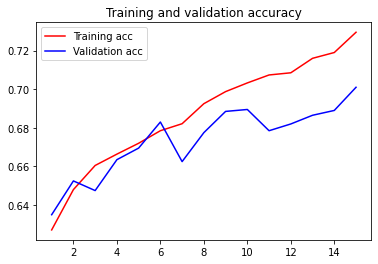

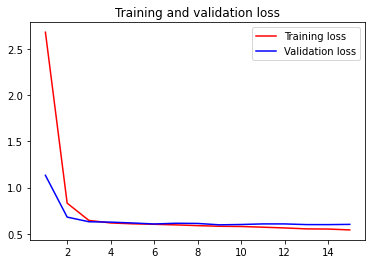

In [0]:
acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(acc) + 1)
val_acc1=max(val_acc)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()
plt.show()

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.text)
X = tokenizer.texts_to_sequences(data.text)
data['words'] = X

In [0]:
X = tokenizer.texts_to_sequences(data.question2)
data['words_quesion2'] = X

In [0]:
X = tokenizer.texts_to_sequences(data.question1)
data['words_quesion1'] = X

In [0]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,text,text_number,question1_number,question2_number,words,words_quesion2,words_quesion1
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...,What step step guide invest share market india...,What step step guide invest share market india,What step step guide invest share market,"[2, 3, 1, 1269, 57, 1269, 2459, 6, 738, 8, 585...","[2, 3, 1, 1269, 57, 1269, 2459, 6, 738, 8, 585...","[2, 3, 1, 1269, 57, 1269, 2459, 6, 738, 8, 585..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor (Koh-i-Noor) Dia...,What story Kohinoor Diamond What would happen ...,What story Kohinoor Diamond,What would happen Indian government stole Kohi...,"[2, 3, 1, 442, 10, 6068, 6069, 4, 6070, 3988, ...","[2, 44, 188, 24, 1, 81, 239, 6071, 1, 6068, 60...","[2, 3, 1, 442, 10, 6068, 6069, 4, 6070, 3988]"
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...,How I increase speed internet connection using...,How I increase speed internet connection using...,How Internet speed increased hacking DNS,"[5, 13, 4, 189, 1, 515, 10, 17, 349, 1782, 236...","[5, 13, 349, 515, 23, 2460, 57, 1054, 192, 9071]","[5, 13, 4, 189, 1, 515, 10, 17, 349, 1782, 236..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely? How can I solve...,Why I mentally lonely How I solve Find remaind...,Why I mentally lonely How I solve,Find remainder math divided,"[16, 70, 4, 2715, 319, 2716, 5, 13, 4, 783, 19...","[85, 1, 3989, 37, 198, 3990, 1907, 198, 3, 480...","[16, 70, 4, 2715, 319, 2716, 5, 13, 4, 783, 19]"
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"Which one dissolve in water quikly sugar, salt...",Which one dissolve water quikly sugar salt met...,Which one dissolve water quikly sugar salt met...,Which fish would survive salt water,"[25, 49, 3991, 8, 228, 9072, 1476, 1783, 4802,...","[25, 3065, 44, 1270, 8, 1783, 228]","[25, 49, 3991, 8, 228, 9072, 1476, 1783, 4802,..."


In [0]:
maxlen = 50
X1 = list(sequence.pad_sequences(data.words_quesion1, 50))
X2 = list(sequence.pad_sequences(data.words_quesion2,50))

In [0]:
word_index = tokenizer.word_index

In [0]:
len(word_index)

15579

In [0]:
unique_words=[*word_index]
unique_words.insert(0, ' ') 
len(unique_words)

15580

In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, 50))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index)+1,
                            50,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

In [0]:
len(X1)

10000

In [0]:
X1_train=X1[:8000]
X1_test=X1[8000:]
X2_train=X2[:8000]
X2_test=X2[8000:]

In [0]:
X1_train = np.array(X1_train)
X2_train = np.array(X2_train)
X1_test = np.array(X1_test)
X2_test = np.array(X2_test)
Y = np_utils.to_categorical(list(data.is_duplicate))
Y_train=Y[:8000]
Y_test=Y[8000:]

In [0]:
def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

In [0]:
input_1 = Input(shape=(maxlen,), dtype='int32')
input_2 = Input(shape=(maxlen,), dtype='int32')

lstm_1 = embedding_layer(input_1)
lstm_2 = embedding_layer(input_2)


common_lstm = LSTM(64,return_sequences=True, activation="relu",recurrent_regularizer=l2(0.5))
vector_1 = common_lstm(lstm_1)
vector_1 = Flatten()(vector_1)

vector_2 = common_lstm(lstm_2)
vector_2 = Flatten()(vector_2)

x3 = Subtract()([vector_1, vector_2])
x3 = Multiply()([x3, x3])

x1_ = Multiply()([vector_1, vector_1])
x2_ = Multiply()([vector_2, vector_2])
x4 = Subtract()([x1_, x2_])
    
    #https://stackoverflow.com/a/51003359/10650182
x5 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])
    
conc = Concatenate(axis=-1)([x5,x4, x3])

x = Dense(100, activation="relu", name='conc_layer')(conc)
x = Dropout(0.01)(x)
out = Dense(2, activation="sigmoid", name = 'out')(x)

model = Model([input_1, input_2], out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 50)       779000      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 50, 64)       29440       embedding_1[0][0]          

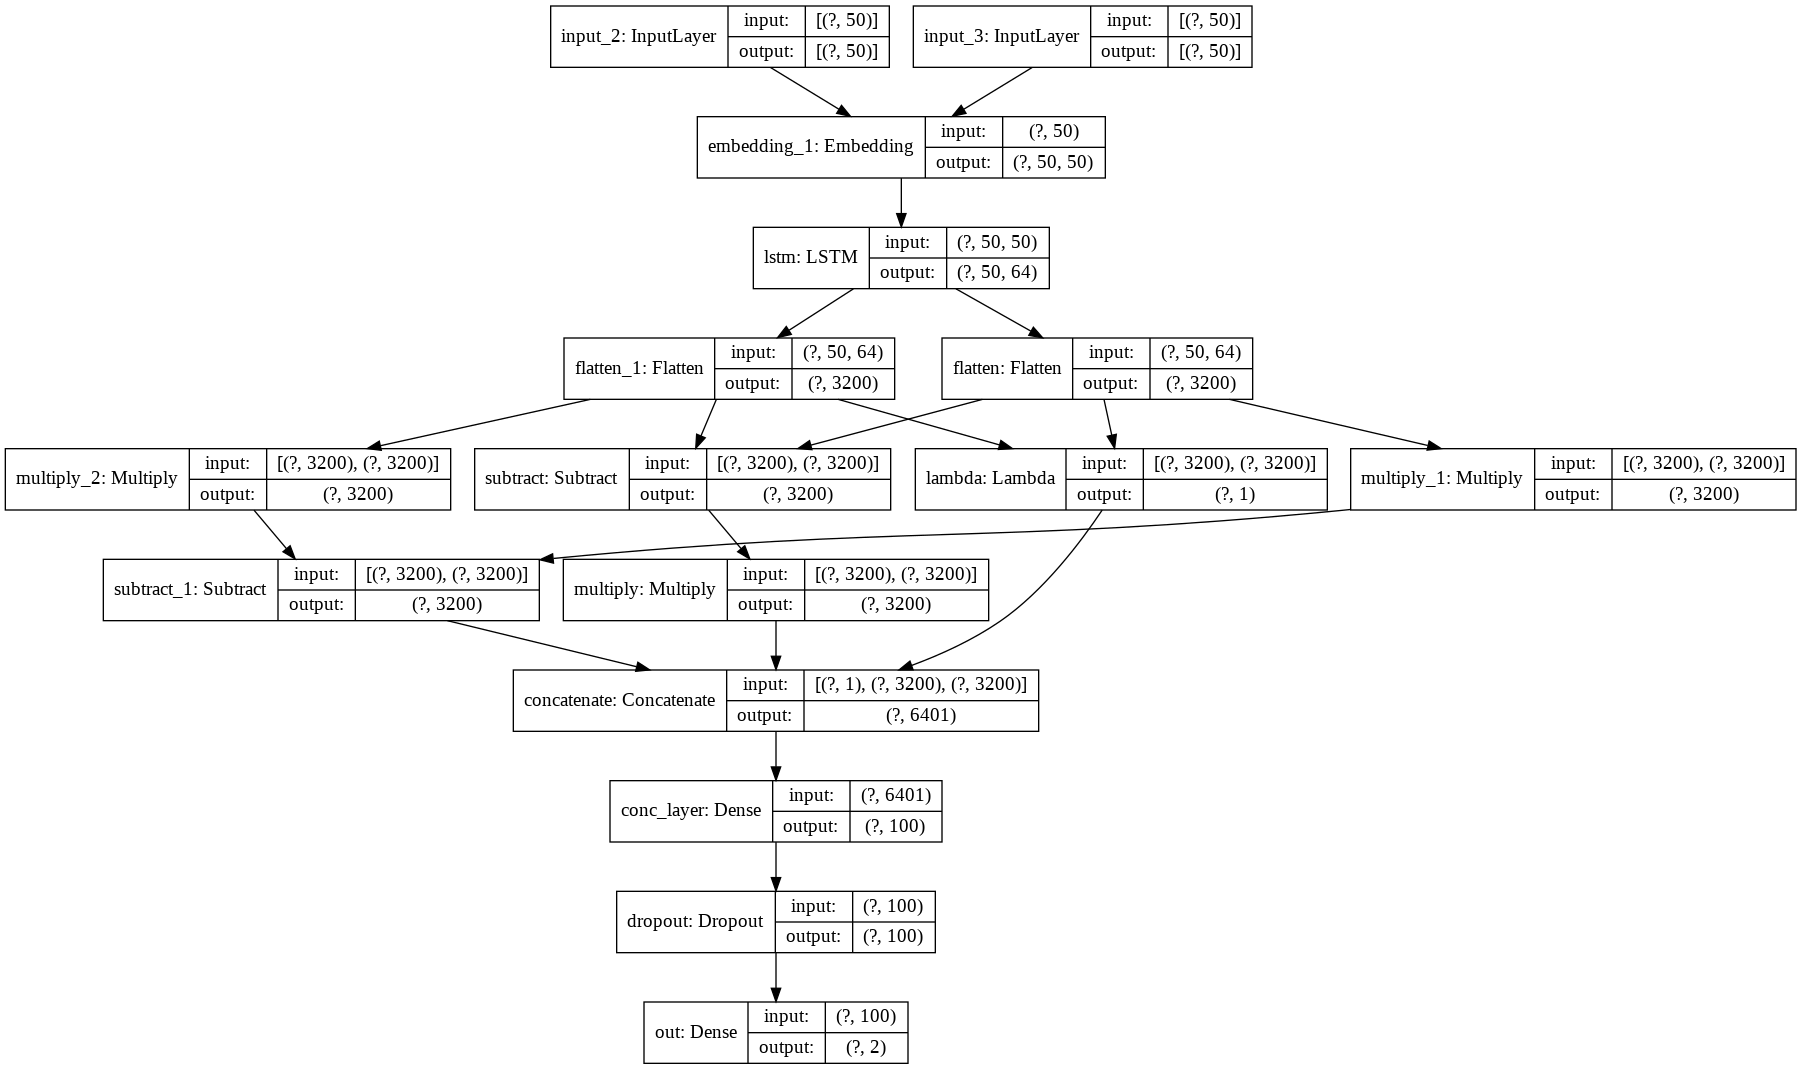

In [0]:
from tensorflow.keras.utils import  plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
model_history1 = model.fit([X1_train,X2_train], Y_train, batch_size=128, epochs=7, validation_data=([X1_test,X2_test], Y_test))

Epoch 1/7
63/63 [==============================] - 9s 150ms/step - loss: 16.3841 - acc: 0.6264 - val_loss: 6.6044 - val_acc: 0.6485
Epoch 2/7
63/63 [==============================] - 8s 127ms/step - loss: 3.5555 - acc: 0.6874 - val_loss: 1.8074 - val_acc: 0.6640
Epoch 3/7
63/63 [==============================] - 8s 131ms/step - loss: 1.1045 - acc: 0.7416 - val_loss: 0.8602 - val_acc: 0.7015
Epoch 4/7
63/63 [==============================] - 8s 134ms/step - loss: 0.5626 - acc: 0.7799 - val_loss: 0.7083 - val_acc: 0.6820
Epoch 5/7
63/63 [==============================] - 8s 134ms/step - loss: 0.4069 - acc: 0.8085 - val_loss: 0.7226 - val_acc: 0.6920
Epoch 6/7
63/63 [==============================] - 8s 134ms/step - loss: 0.3301 - acc: 0.8439 - val_loss: 0.8225 - val_acc: 0.6940
Epoch 7/7
63/63 [==============================] - 9s 136ms/step - loss: 0.2738 - acc: 0.8725 - val_loss: 0.9395 - val_acc: 0.7000


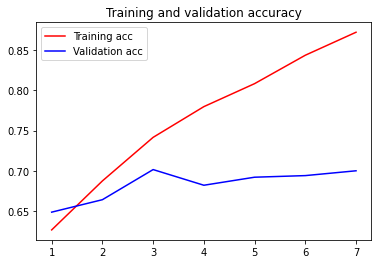

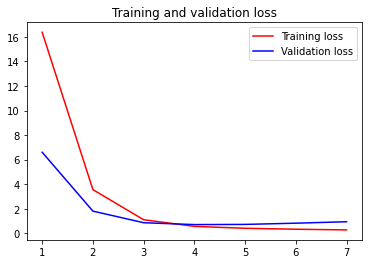

In [0]:
acc = model_history1.history['acc']
val_acc = model_history1.history['val_acc']
loss = model_history1.history['loss']
val_loss = model_history1.history['val_loss']
epochs = range(1, len(acc) + 1)
val_acc1=max(val_acc)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()
plt.show()

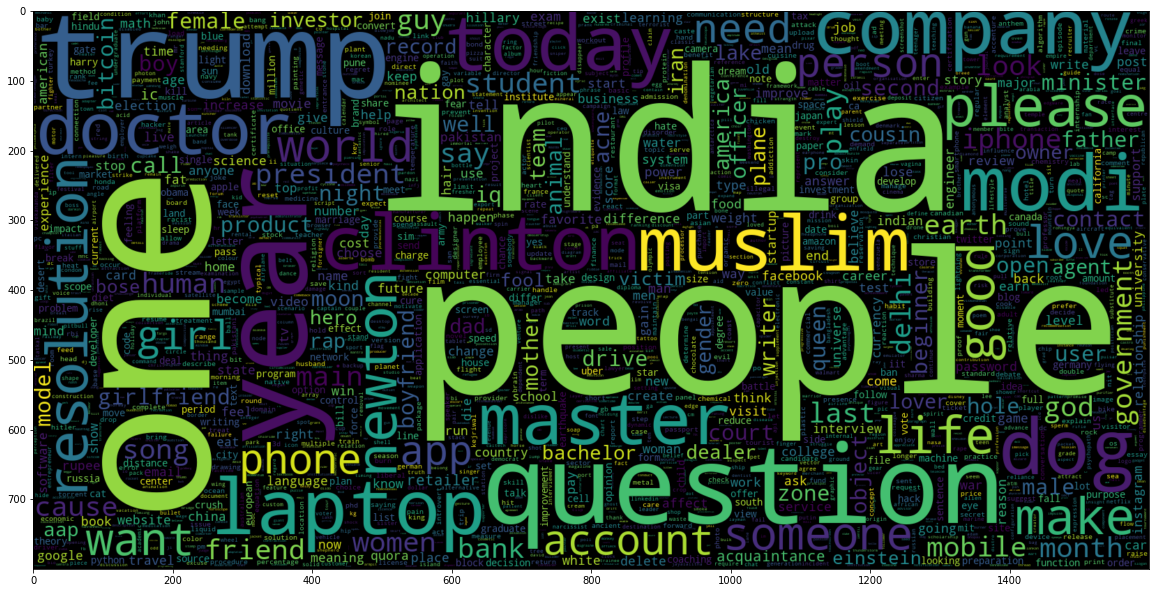

In [0]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text Reviews with Poor Ratings
wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1600 , height = 800).generate(" ".join(unique_words))
plt.imshow(wc,interpolation = 'bilinear')

In [0]:
acc=dict({'LSTM':70.10,'CNN':69.10,'LR-TF_IDF':62.6,'LR-BOW':67.55,'MNB-TF_IDF':67.75,'MNB-BOW':68.05,'XGB':62.45,'RF':62.45,'Siamese':70.15})
acc

{'CNN': 69.1,
 'LR-BOW': 67.55,
 'LR-TF_IDF': 62.6,
 'LSTM': 70.1,
 'MNB-BOW': 68.05,
 'MNB-TF_IDF': 67.75,
 'RF': 62.45,
 'Siamese': 70.15,
 'XGB': 62.45}

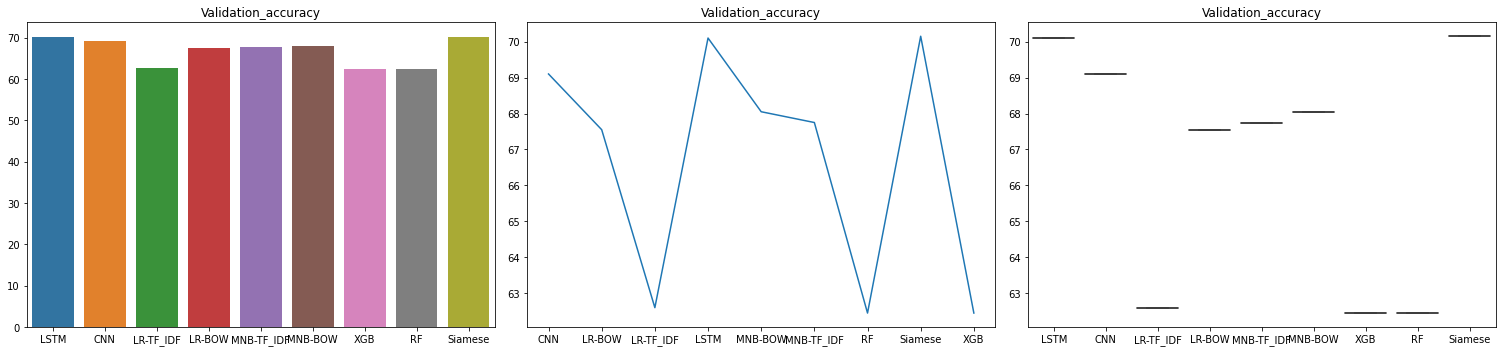

In [0]:
fig = plt.figure(figsize=(21,5))

#  subplot #1
fig.add_subplot(1,3,1)
sns.barplot(x=[*acc],y=list(acc.values())).set_title('Validation_accuracy')

#  subplot #2
fig.add_subplot(1,3,2)
sns.lineplot(x=[*acc],y=list(acc.values())).set_title('Validation_accuracy')

#  subplot #3
fig.add_subplot(1,3,3)
sns.boxplot(x=[*acc],y=list(acc.values())).set_title('Validation_accuracy')
plt.tight_layout()